In [1]:
using PyPlot # Plotting using matplotlib Python library
using DelimitedFiles # Reading and writing files (e.g. txt)

using Plots # Plotting using Julia library. i use this for the animations as it is easier than PyPlot
using Plots.PlotMeasures # For setting the size of the plots
using LaTeXStrings # For LaTeX in plots with Julia

using Random
using Distributions

using Glob

include("IBM_Allee_lib.jl") # The self-written library for the IBM

IBM_save_all (generic function with 1 method)

# Single simulation

In [2]:
L = 20.0 # System size (length of the square)

N = Int(L^2) # Initial number of particles

P = rand(Float64, (2, N)) * L .- L/2 # Uniform initial distribution
# P = randn(Float64, (2, N)) * 4 / 2 # Gaussian initial distribution

dist = zeros(N, N) # Initialize distance matrix

γ_c = 1.05 # Competition strength
γ_p = 1.1 # Proliferation (cooperation) strength

σ_c = 0.5 # Competition noise
σ_p = 0.5 # Proliferation (cooperation) noise
σ_d = 0.3 # Diffusion (in offspring) noise

p = 0.0 # Proliferation (cooperation) rate
c = 0.02 # Competition rate

f = 2.2 # Factor for which the proliferation rate is multiplied when there is High Precipitation

t_max = 100.0 # Time at which the simulation will finish.

# Create switching times
l = 0 
λ = 0.1 # Switching rate
d = 25 # Duration of the period

distribution = Exponential(1.0/λ) # Exponential distribution for the duration of the periods

periods = []

while l < t_max*2 # Generate periods until the end of the simulation (and a little more for safety)

    # l += -λ * log(rand())
    l += rand(distribution)

    append!(periods, l)

    l += d

end

periods = convert(Array{Float64,1}, periods) # Convert to float array

# periods = [Inf] #Uncomment this line to disable switching

rates = zeros(3, N) # Init variables and parameters

# Init variables and parameters (don't need to touch this, it gets the values from the constants above)

total_rates = zeros(2) 

constants = [γ_c, σ_c, γ_p, σ_p, σ_d, c, p, d, f]

vars = Variables(P, dist, rates, N, periods)

params = Parameters(constants, total_rates, L)

# Simulate
N_t, t_arr = @time IBM(t_max, vars, params);

Switching to HP at t = 21.52434336391979
Switching to LP at t = 46.524773633724486
Switching to HP at t = 65.35852664226951
Switching to LP at t = 90.3590263186858
 22.982772 seconds (396.47 M allocations: 72.189 GiB, 16.93% gc time, 6.55% compilation time)


## Plot

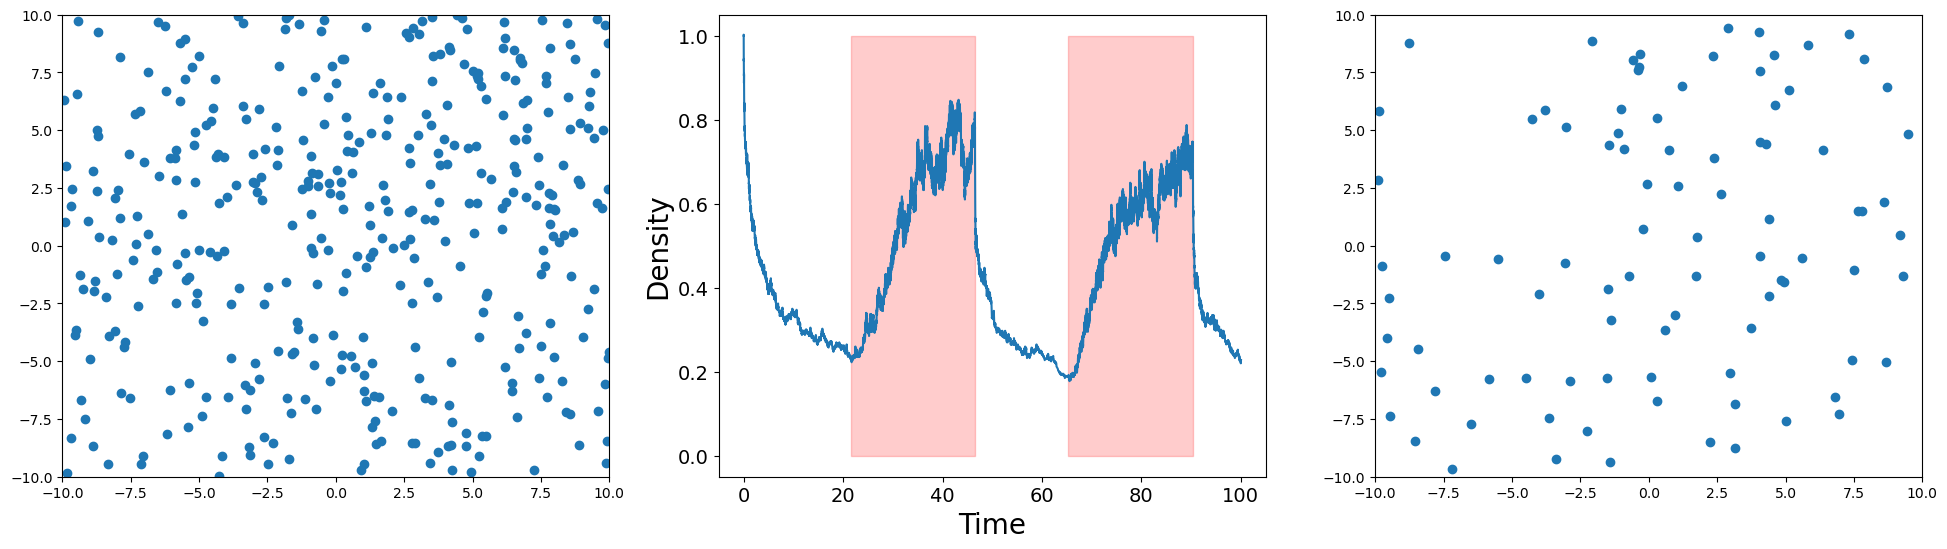

In [3]:
N_t_light = N_t[1:1:end]
t_arr_light = t_arr[1:1:end]

fig, ax = plt.subplot_mosaic("""ABC""", figsize=(8*3, 6))

ax["A"].scatter(P[1,:], P[2,:])

ax["A"].set_ylim(-L / 2, L / 2)
ax["A"].set_xlim(-L / 2, L / 2)

ax["B"].plot(t_arr_light, N_t_light / L^2)

ax["B"].set_ylabel("Density", fontsize=20)
ax["B"].set_xlabel("Time", fontsize=20)

ax["B"].tick_params(labelsize=14)

for period in periods

    if period > t_arr[(N_t .> 0)][end]
        break
    end

    ax["B"].fill_betweenx([0, 1], period, period + d, color="red", alpha=0.2)

end

ax["B"].set_ylim(-0.05, 1.05)

ax["C"].scatter(vars.P[1,:], vars.P[2,:])

ax["C"].set_ylim(-L/2, L/2)
ax["C"].set_xlim(-L/2, L/2)

plt.savefig("tests/Test_switching_c_$(c)_f_$(f)_lambda_$(λ)_d($d).png", dpi=300)

gcf()


# Simulate for animation

In [4]:
save_at = 1.0 # Save every save_at time steps (approx)

folder = "Example_simulation"

# In the folder does not exist, create it
if !isdir(folder)
    mkdir(folder)
else
    println("Warning: folder $folder already exists. Files will be removed.")
    println("You have 10 seconds to cancel if you don't want this.")
    sleep(10) # Wait 10 seconds to give the user time to cancel if needed
    rm(folder, recursive=true)
    mkdir(folder)
    println("Folder $folder has been cleared.")
end

L = 20.0 # System size (length of the square)

N = Int(L^2) # Initial number of particles

P = rand(Float64, (2, N)) * L .- L/2 # Uniform initial distribution
#P = randn(Float64, (2, N)) * 4 / 2 # Gaussian initial distribution

dist = zeros(N, N) # Initialize distance matrix

γ_c = 1.05 # Competition strength
γ_p = 1.1  # Proliferation (cooperation) strength

σ_c = 0.5 # Competition noise
σ_p = 0.5 # Proliferation (cooperation) noise
σ_d = 0.3 # Diffusion (in offspring) noise

p = 0.0 # Proliferation (cooperation) rate
c = 0.02 # Competition rate

f = 2.2 # Factor for which the proliferation rate is multiplied when there is High Precipitation

t_max = 100.0 # Time at which the simulation will finish.

# Create switching times
l = 0 
λ = 0.1 # Switching rate
d = 25 # Duration of the period

distribution = Exponential(1.0/λ) # Exponential distribution for the duration of the periods

periods = []

while l < t_max*2 # Generate periods until the end of the simulation (and a little more for safety)

    l += rand(distribution)

    append!(periods, l)

    l += d

end

periods = convert(Array{Float64,1}, periods) # Convert to float array

# periods = [Inf] #Uncomment this line to disable switching

rates = zeros(3, N) # Init variables and parameters

# Init variables and parameters (don't need to touch this, it gets the values from the constants above)
total_rates = zeros(2)

constants = [γ_c, σ_c, γ_p, σ_p, σ_d, c, p, d, f]

vars = Variables(P, dist, rates, N, periods)

params = Parameters(constants, total_rates, L)

# Simulate
@time IBM_save_all(t_max, vars, params; folder=folder);

You have 10 seconds to cancel if you don't want this.
Folder Example_simulation has been cleared.
Switching to HP at t = 0.6637299809329357
Switching to LP at t = 25.663754046752263
Switching to HP at t = 53.381196141945544
Switching to LP at t = 78.38157623252611
 28.545815 seconds (490.81 M allocations: 99.475 GiB, 17.58% gc time, 0.54% compilation time)


## Create animation

In [5]:
folder = "Example_simulation" # Same name as before

# Read all files from folder
filenames = glob("P*.txt", folder)

N_t = readdlm(string(folder, "/N_t.txt")) # Read the number of particles
t_arr = readdlm(string(folder, "/t_res.txt")) # Read the time array

# Split . and _ to get the time of each file
ts = []
for filename in filenames

    name = split(filename, "/")[2] # Get the file name without the path

    t_i = split(name, "_")[2][1:end-4]

    # as float
    t_i = parse(Float64, t_i)

    append!(ts, t_i)

end

ts = sort(ts) # Sort the times

anim = @animate for t in ts

    i = findfirst(x -> x == t, ts) # Find the index of the time

    P = readdlm(string(folder, "/P_", t, ".txt"))

    # Plot initial frame
    p1 = Plots.plot(t_arr[1:i], N_t[1:i] / L^2, xlabel=L"t", ylabel=L"\rho", legend=false, ylim=(0, 2), linewidth=5, titlefont=25,
        tickfontsize=14, guidefontsize=25, legendfontsize=16, title=L"$\rho(t)$", size=(800, 600), framestyle=:box, grid=false, dpi=300)

    p2 = Plots.scatter(P[1, :], P[2, :], xlabel=L"x", ylabel=L"y", legend=false, ylim=(-L / 2, L / 2), xlim=(-L / 2, L / 2), markersize=5, tickfontsize=14,
        guidefontsize=25, legendfontsize=16, title=L"$\vec{r}(t)$", titlefont=25, size=(800, 600), framestyle=:box, grid=false, dpi=300)

    # subplot
    Plots.plot(p1, p2, layout=(1, 2), size=(800 * 2, 600), dpi=300, margin=7mm, left_margin=10mm, right_margin=10mm, top_margin=10mm, bottom_margin=10mm)

end

# save anim as gif
#gif(anim, string("Switching_", folder, ".gif"), fps=10)

# save as mp4
mp4(anim, string(folder, ".mp4"), fps=10)

┌ Info: Saved animation to /home/alex/IMPORTANT/Alle Effect/Example_simulation.mp4
└ @ Plots /home/alex/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/alex/IMPORTANT/Alle Effect/Example_simulation.mp4")